# Logistic Regression for Classification of Handwritten Digits

In [1]:
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import pandas as pd
from numpy import *
from matplotlib.pyplot import *
from load_mnist import *
matplotlib.rcParams.update({'font.size': 18})
# Set global font size for mpl

%load_ext autoreload
%autoreload 2

## Conventions for this notebook:

y = labels,

X = features,

in function documentation I:/O: = Input:/Output: 

We have used capital letters in some variables to denote the fact that they pertain to the multinomial logistic portion of the problem. 

While 'w' refers simply to a single set of weights, 
'W' is used for an array of such sets of weights.

## Defining our 'subfunctions'

In [2]:
def sigmoid(t): 
    return 1/(1+e**-t)

def decision_boundary(p, boundary=0.5): 
    """step function that outputs a classification"""
    return 1 if p >= boundary else 0 

## Defining our 'data initialization' functions

In [3]:
images_tr, labels_tr = load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')

def init_train():
    y, X = labels_tr, images_tr
    X = X - X.mean()
    X = X / X.max()
    X = c_[ones((y.shape[0], 1)), X]
    XT = X.T
    return y, X, XT

def init_test():
    y, X = labels_tst, images_tst
    X = X - X.mean()
    X = X / X.max()

    X = c_[ones((y.shape[0], 1)), X]
    XT = X.T
    return y, X, XT

def init_binary(y, X):
    remove = []
    for i in enumerate(y):
        if i[1]== 0:
            pass
        elif i[1]== 1:
            pass
        else:
            remove.append(i[0])
            
    y = delete(y, remove)
    X = delete(X, remove, axis=0)
    
    X = X - X.mean()
    X = X / X.max()
    XT = X.T
    return y, X, XT

# GRADIENT DESCENT

## Defining our Loss and Gradient functions

In [4]:
def calculate_loss(y, X, w):
    """
    I: labels, features, weights
    O: Loss
    Computes loss/ the negative log likelihood
    """
    z = sigmoid(dot(X, w))
    loss = -sum((1 - y)*log(1-z)+ y*log(z))/len(y)
    return loss

def calculate_gradient(y, X, XT, w):
    """
    O: the derivative of Loss w.r.t each paramater
    """
    z = sigmoid(dot(X, w))
    gradient = dot(XT, z-y)/len(y)
    return gradient

## Defining the weight update function

In [5]:
def update_weights(y, X, XT, w, tau):
    """
    I: labels, features, weights, learning rate
    O: new and improved weights
    """
    gradient = calculate_gradient(y, X, XT, w)
    
    gradient *= tau
    w -= gradient
    return w

## Defining one gradient descent 'step'

In [6]:
def gradient_descent_step(y, X, XT, w, tau):
    """
    I: tau - 'learning rate'
    O: loss for new weights, arr new weights
    """
    new_weights = update_weights(y, X, XT, w, tau)
    loss = calculate_loss(y, X, new_weights)
    return loss, new_weights

# Performing Binary Gradient Descent  

In [7]:
def logistic_regression_gradient_descent(y, X, tau, max_iter, digit=""):
    """
    I: labels, features, learning rate, max iterations, digit: used for tqdm decorator
    O: arr losses, arr w
    """
    # init parameters
    threshold = 1e-8
    losses = []
    w = np.zeros(785)
    # start the logistic regression
    for iter in tqdm(range(max_iter), leave=False, desc=f'Training Digit: {digit}'):
        # get loss and update w.
        loss, w = gradient_descent_step(y, X, XT, w, tau)
        # log info

        
        if iter % 100 == 0:
            print(f"loss = {loss:.7f}")
            
        # converge criterion
        
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
            
    print("\nFinal loss = {}".format(calculate_loss(y, X, w)))
    print(f'Minimum loss = {min(losses)}')
    return losses, w 

In [8]:
y, X, XT = init_train()
y, X, XT = init_binary(y, X)

GD_losses, best_GD_w = logistic_regression_gradient_descent(y, X, 1.5, 1000, 1)

A Jupyter Widget

loss = 0.0126838
loss = 0.0046068
loss = 0.0031352
loss = 0.0025506
loss = 0.0022187
loss = 0.0019858
loss = 0.0018066
loss = 0.0016623
loss = 0.0015428
loss = 0.0014418

Final loss = 0.0013556080876733273
Minimum loss = 0.0013556080876733273


Binary GD training times: 1.53 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

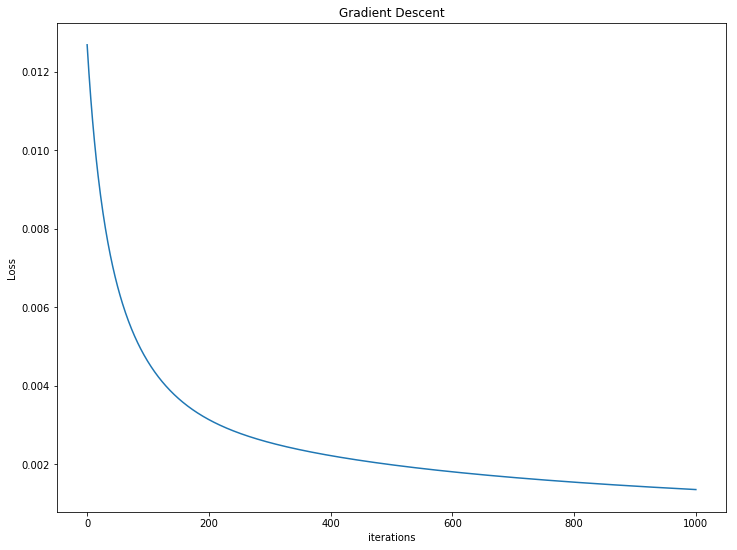

In [16]:
figure(figsize=(12, 9))
title('Gradient Descent')
ylabel('Loss')
xlabel('iterations')
plot(linspace(0, len(GD_losses),len(GD_losses)), GD_losses)
savefig('GD_loss.png')
show()

In [17]:
y, X, XT = init_train()
y, X, XT = init_binary(y, X)

## NEWTON METHOD

### Calculating the Hessian

In [18]:
def calculate_hessian(y, X,XT, w, alpha):
    """
    O: return the hessian of the loss function.
    
    hessian not invertible - singular therefore hessian penalise = hessian + alpha * identity matrix 
    x ̃i σ(x ̃Ti w)(1 − σ(x ̃Ti w)) x ̃Ti
    """
    z = sigmoid(dot(X, w))
    k = 1 - z
    S = z*k 
    
    S_matrix = np.eye(len(y))
    np.fill_diagonal(S_matrix, S)
    
    hessian = XT.dot((S_matrix).dot(X))
    hessian_penalise = hessian + alpha*np.identity(hessian.shape[0])
    return hessian_penalise

### Inverting Hessian

In [19]:
w = np.zeros(785)
hessian_penalise = calculate_hessian(y, X, XT, w, 0.1)
hessian_inv = np.linalg.inv(hessian_penalise)

## Implementing the Newton Method

In [20]:
def learning_by_newton_method(y, X, XT, w, alpha):
    hessian_penalise = calculate_hessian(y, X, XT, w, alpha)
    hessian_inv = np.linalg.inv(hessian_penalise)                 

    gradient = calculate_gradient(y, X, XT, w)
    w -= ((hessian_inv).dot(gradient))
    loss = calculate_loss(y, X, w)
    return loss, w

In [21]:
def logistic_regression_newton_method_demo(y, X, XT, alpha, max_iter, digit=''):
    """
    I: int digit (tqdm decorator info), alpha
    O: arr losses, arr 'best' weights
    """
    threshold = 1e-8
    losses = []
    w = np.zeros(785)

    for iter in tqdm(range(max_iter), leave=False, desc=f'Training Digit: {digit}'):

        loss, w = learning_by_newton_method(y, X, XT, w,alpha)
        losses.append(loss)

        if iter % 100 == 0:
            print(f"loss = {loss:.7f}")
        
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print(f"\nFinal loss = {losses[-1]}")
    print(f'Minimum loss = {min(losses)}')
    return losses, w

In [22]:
y, X, XT = init_train()
y, X, XT = init_binary(y, X)

#NR abbr. Newton-Raphson
NR_losses, best_newton_w = logistic_regression_newton_method_demo(y, X, XT, 5, 1000, 1) 

A Jupyter Widget

loss = 0.6930707
loss = 0.6854867
loss = 0.6780204
loss = 0.6706691
loss = 0.6634302
loss = 0.6563009
loss = 0.6492790
loss = 0.6423619
loss = 0.6355473
loss = 0.6288330

Final loss = 0.6222825011092564
Minimum loss = 0.6222825011092564


NR training time: 3min 1s ± 10.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

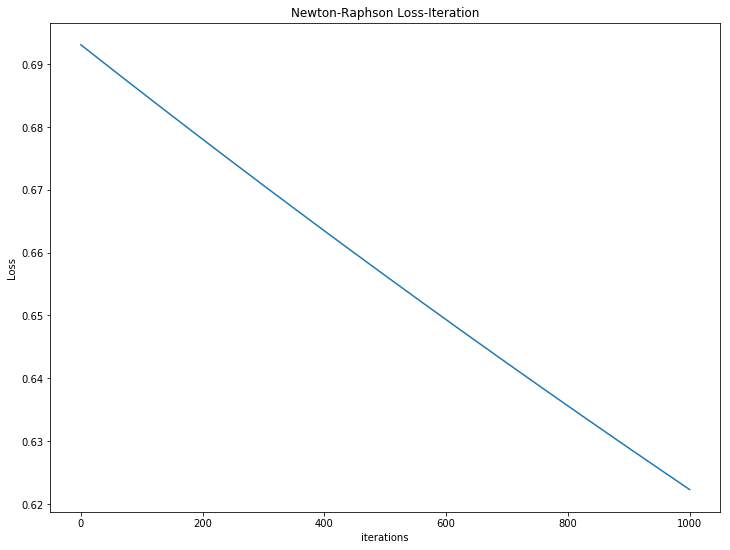

In [24]:
savetxt('best_newton_w', best_newton_w)
figure(figsize=(12, 9))
title('Newton-Raphson Loss-Iteration')
ylabel('Loss')
xlabel('iterations')
plot(linspace(0, len(NR_losses),len(NR_losses)), NR_losses)
savefig('NR_loss.png')
show()

## Penalised Logistic Regression (Ridge)

In [25]:
def penalised_logistic_regression(y, X, w,tau,alpha):
    """
    I: alpha (penalization coefficient (hyperperameter))
    O: arr loss, arr updated weights
    """
    L = calculate_loss(y, X, w)
    R = (alpha/2) * sum(square(w))
    
    loss = L + R
    gradient = (calculate_gradient(y, X, XT, w) + alpha*w)*tau
    w -= gradient
    return loss, w

In [26]:
def logistic_regression_ridge_demo(y, X, tau, alpha, max_iter, digit=''):
    """O: arr losses, arr 'best' weights"""
    
    threshold = 1e-8
    losses = []
    w = np.zeros(785)
        
    for iter in tqdm(range(max_iter), leave=False, desc=f'Training Digit: {digit}'):
        # get loss and update w.
        loss, w = penalised_logistic_regression(y, X, w, tau,alpha)
    # log info
        if iter % 100 == 0:
            print(f"loss = {loss:.7f}")
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            print(f'\nLoss has converged to {threshold} decimal places')
            break
    print(f"\nFinal loss = {losses[-1]}")
    print(f'Minimum loss = {min(losses)}')
    return losses, w

In [27]:
y, X, XT = init_train()
y, X, XT = init_binary(y, X)

RR_losses, best_ridge_w = logistic_regression_ridge_demo(y, X, 0.01, 0.1, 1000, 1)

A Jupyter Widget

loss = 0.6931472
loss = 0.1150775
loss = 0.0921135
loss = 0.0865907
loss = 0.0846925
loss = 0.0839139
loss = 0.0835525
loss = 0.0833665
loss = 0.0832616
loss = 0.0831977

Final loss = 0.08315661990410214
Minimum loss = 0.08315661990410214


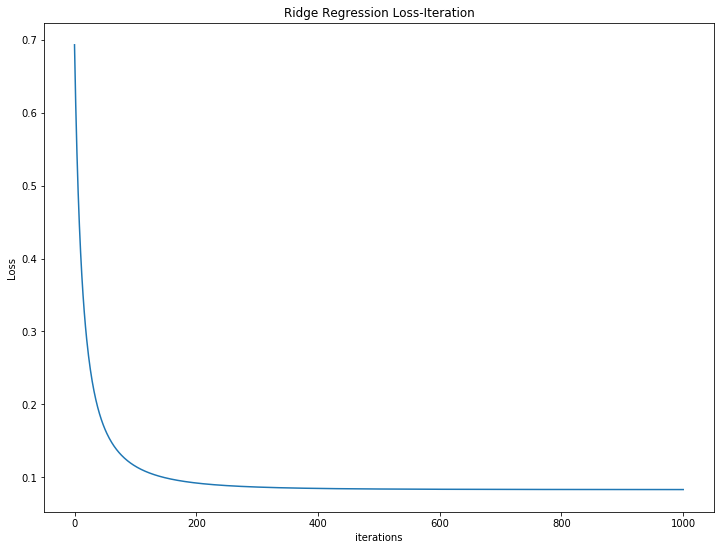

In [28]:
figure(figsize=(12, 9))
title('Ridge Regression Loss-Iteration')
ylabel('Loss')
xlabel('iterations')
plot(linspace(0, len(RR_losses),len(RR_losses)), RR_losses)
savefig('RR_loss.png')
show()

# Multinomial Logistic Regression and Softmax

## Creating a new set of labels corresponding to each individual digit

In [29]:
images_tr, labels_tr = load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')

y, X = labels_tr, images_tr

def re_label(y, digit):
    """
    I: array of labels, positive class label
    O: array of binary labels 1 for positive class 0 else 
    """
    new_labels = [1 if x == digit else 0 for x in y]
    return new_labels

Y = []
for i in range(10):
    Y.append(re_label(y, i))

## Training One vs All for each digit

In [ ]:
y, X, XT = init_train()

def train_model(y, X, tau, max_iter):
    Y = []
    L = []
    for i in range(10):
        Y.append(re_label(y, i))

    all_optimal_weights = []
    
    for i in tqdm(range(10)):
        Y = np.array(Y)
        
        var1,var2 = logistic_regression_gradient_descent(Y[i], X, tau, max_iter, i)
        L.append(var1)
        all_optimal_weights.append(var2)      
        
    print(shape(all_optimal_weights))
    return L, all_optimal_weights

training_losses, all_optimal_weights = train_model(y, X, 1.5, 1000)

W = array(all_optimal_weights).T

# This allows us to save our weights/ losses for later model use and for analysis respectively
savetxt('training_losses', training_losses)
savetxt('Optimized_W', W)

# Analytics: Binary

## Classes [0, 1]

## RESULTS

In [30]:
y, X, XT = init_test()
y, X, XT = init_binary(y, X)
best_newton_w = loadtxt('best_newton_w')

zGD = sigmoid(dot(X, best_GD_w))
zNR = sigmoid(dot(X, best_newton_w))
zRR = sigmoid(dot(X, best_ridge_w))

def decision_boundary(p): 
    """step function that outputs a classification"""
    return 1 if p >= 0.5 else 0 

decision_boundary = vectorize(decision_boundary)

zGD = decision_boundary(zGD)
zNR = decision_boundary(zNR)
zRR = decision_boundary(zRR)

resultsGD = (nonzero(abs(y-zGD)))
resultsNR = (nonzero(abs(y-zNR)))
resultsRR = (nonzero(abs(y-zRR)))

print(f'Indices of Incorrect binary classifications for each model:\n\n{len(y)} total classifications\tTotal Errors: \tError Indices:\n ')
print(f'Gradient Descent:\t\t{len(resultsGD[0])} \t\t{resultsGD[0]}')
print(f'Newton-Raphson:  \t\t{len(resultsNR[0])} \t\t{resultsNR[0]}')
print(f'Ridge Regression:\t\t{len(resultsRR[0])} \t\t{resultsRR[0]}')

Indices of Incorrect binary classifications for each model:

2115 total classifications	Total Errors: 	Error Indices:
 
Gradient Descent:		2 		[1388 2031]
Newton-Raphson:  		7 		[ 361  626 1068 1105 1130 1172 2031]
Ridge Regression:		3 		[1388 2031 2087]




	   Gradient Descent			   Newton-Raphson			Ridge Regression


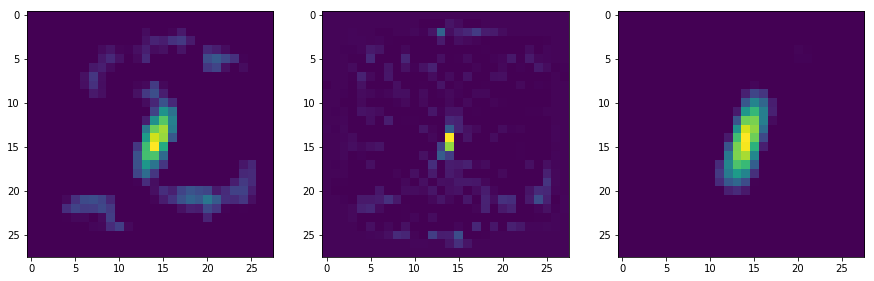

In [31]:
binary_optimum_weights = [best_GD_w, best_newton_w, best_ridge_w]
figure(figsize=(15, 8))

for index,i in enumerate(binary_optimum_weights):
    subplot(1, 3,index+1)
    wT = i[-784:]
    imshow(np.reshape(wT,(28,28)), cmap=cm.viridis, vmin=0.00)
print('\n\n\t   Gradient Descent\t\t\t   Newton-Raphson\t\t\tRidge Regression')
show()

## Error Analysis

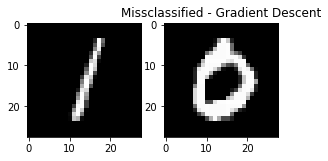

In [33]:
y, X, XT = init_test()
y, X, XT = init_binary(y,X)

figure(figsize=(4.5, 8))
for index,i in enumerate(resultsGD[0]):
    subplot(1, len(resultsGD[0]),index+1)
    imshow(np.reshape(X[index][-784:],(28,28)), cmap=cm.gray)
title('Missclassified - Gradient Descent')
show()

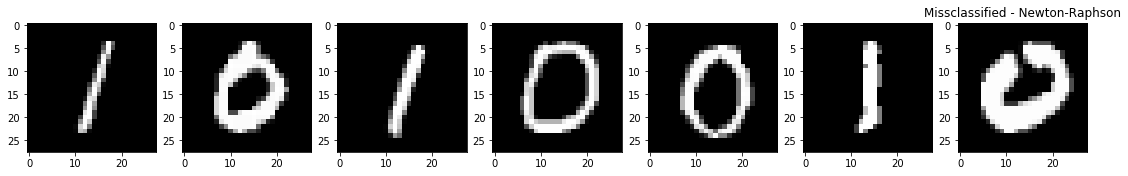

In [34]:
figure(figsize=(19, 20))
for index,i in enumerate(resultsNR[0]):
    subplot(1, len(resultsNR[0]),index+1)
    imshow(np.reshape(X[index][-784:],(28,28)), cmap=cm.gray)
title('Missclassified - Newton-Raphson')
show()

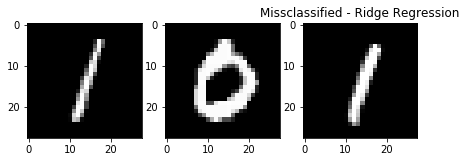

In [35]:
if len(resultsRR[0]) != 0:
    figure(figsize=(7, 8))
    for index,i in enumerate(resultsRR[0]):
        subplot(1, len(resultsRR[0]),index+1)
        imshow(np.reshape(X[index][-784:],(28,28)), cmap=cm.gray)
    title('Missclassified - Ridge Regression')
    show()

# Analytics: Multinomial Regression

## Error Analysis

In [36]:
W = loadtxt('Optimized_W')
# W is an array of our best weights with each row corresponding to a distinct digit. 

y, X, XT = init_test()
Z = X.dot(W)
# Z is a matrix with rows corresponding to each digit.

In [37]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

def choosemax_prediction(x):
    """Select largest probability's index to be our prediction"""
    x = [1 if y == max(x) else 0 for y in x]
    return argmax(x)

predictions = apply_along_axis(choosemax_prediction, axis=1, arr=apply_along_axis( softmax, axis=1, arr=Z ))

errors = abs(y-predictions)
error_indices = nonzero(errors)

cumulative_errors = shape(nonzero(errors))[1]

print(f'Test samples:\t{len(y)}\nTotal errors:\t{cumulative_errors}\nError rate:\t{100*cumulative_errors/len(y)}%')

Test samples:	10000
Total errors:	819
Error rate:	8.19%


## Displaying our final weights

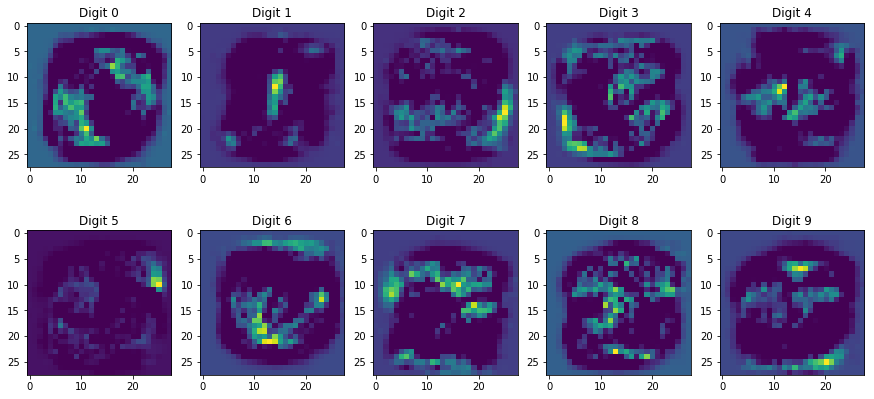

In [38]:
WT = W.T
ImWeights = []

for i in range(shape(WT)[0]):
    ImWeights.append(WT[i][-784:])

figure(figsize=(15,7))

for i in range(10):
    subplot(2, 5,i+1)
    image = ImWeights[i]
    imshow(np.reshape(image, (28,28)), cmap=cm.viridis, vmin=0.00)
    title(f'Digit {i}')
show()

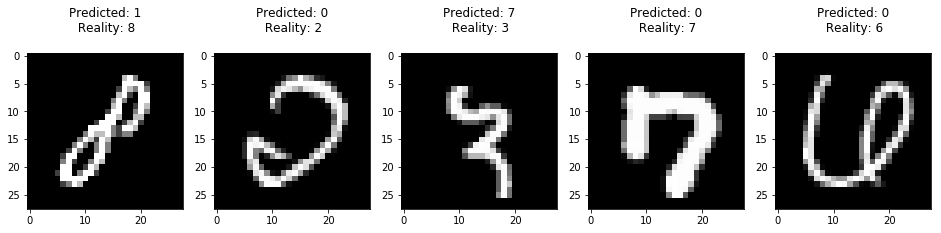

In [39]:
import random

error_images = images_tst[error_indices]
error_labels = labels_tst[error_indices]
error_predictions = predictions[error_indices]

figure(figsize=(16.2,5))
i = random.randint(5, len(error_predictions))

for index, (image, label, predicted) in enumerate(zip(error_images[i:i+5], error_labels[i:i+5], error_predictions[i:i+5])):
    subplot(1, 5, index + 1)
    imshow(np.reshape(image, (28,28)), cmap=cm.gray)
    title('Predicted: {}\n Reality: {}\n'.format(predicted, label, fontsize = 20))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


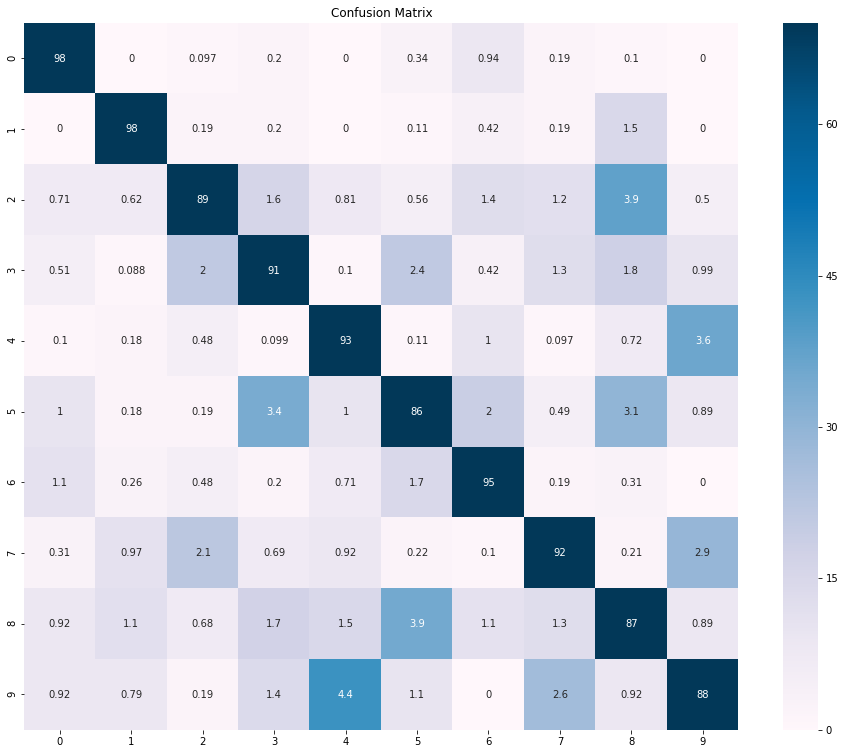

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import collections

A = sorted(list(collections.Counter(labels_tst).items()))

samples_arr = array(([i[1]for i in A]))
temp = 100*(confusion_matrix(labels_tst, predictions))/samples_arr

figure(figsize = (16,13))
title('Confusion Matrix')
xlabel(predictions)

# Edited vmax values for viewability. 
sn.heatmap((confusion_matrix(labels_tst, predictions)), annot=temp, vmax= 70, cmap='PuBu')
savefig('Multinomial_Confusion_Matrix.png')
show()